# 06 Raster2 Demo
## Reprojection, Clipping, Sampling, Zonal Stats

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean, Eric Gagliano, Quinn Brencher


## Objectives
* Demonstrate multiple approaches for "on-the-fly" raster data download
* Understand additional fundamental raster processing/analysis:
    * Reprojection
    * Clipping
    * Interpolation and sampling strategies
* Combine vector points and polygons with rasters for zonal statistics
* Understand processing strategies, derivative products, and common applications for a fundamental raster data product: DEMs
    * Slope and Aspect
    * Contour generation
    * Volume estimation (cut/fill analysis)

## What is a DEM?
DEM = Digital Elevation Model

A generic term for a 2D raster grid with values representing surface elevation above some datum (e.g., WGS84 ellispoid or a geoid model representing mean sea level).  Sometimes called 2.5D, as it's not a true 3D dataset containing some value (e.g., temperature) at each (x,y,z) point.

There are subtypes:
* DSM = Digital Surface Model ("first-return" model includes top of canopy, buildings, etc.)
* DTM = Digital Terrain Model (bare ground model, with canopy, buildings, etc. removed)

Great resource on LiDAR and derivative products: 
* https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/
* https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/lidar-chm-dem-dsm/

### Airborne LiDAR example
* https://www.dnr.wa.gov/lidar
* https://wadnr.maps.arcgis.com/apps/Cascade/index.html?appid=b93c17aa1ef24669b656dbaea009b5ce
* https://wadnr.maps.arcgis.com/apps/Cascade/index.html?appid=36b4887370d141fcbb35392f996c82d9
* https://lidarportal.dnr.wa.gov/

### SRTM
SRTM = Shuttle Radar Topography Mission  
* https://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission
* https://www2.jpl.nasa.gov/srtm/

This week, we'll play with the landmark SRTM dataset.  We briefly introduced this during Lab03, as I sampled the SRTM products for the GLAS point locations and included as the `dem_z` column in the csv.
* Collected February 11-22, 2000 (winter)
* Single-track InSAR (interferometric synthetic aperture radar) instrument
* Coverage: 56°S to 60°N (the shuttle orbit, plus radar look direction)
* Tiled in 1x1° raster data at different resolutions: 
    * 1-arcsecond (~30 m)
    * 3-arcsecond (~90 m)
* Default elevation values in the SRTM tiles are relative to the EGM96 geoid (approximates mean sea level), not the WGS84 ellipsoid (as with the GLAS points)

For this lab, we'll use the 3-arcsec (90 m) SRTM product for WA state to learn some new concepts.  This is a relatively small dataset, with a limited number of 1x1° tiles required for WA state.  However, the approaches we'll learn (e.g., API subsetting, using vrt datasets), scale to larger datasets that are too big to fit in memory (like operations on the global SRTM dataset). 

### Copernicus DEM
* https://spacedata.copernicus.eu/web/cscda/dataset-details?articleId=394198
* https://spacedata.copernicus.eu/documents/20126/0/GEO1988-CopernicusDEM-SPE-002_ProductHandbook_I1.00.pdf
* https://spacedata.copernicus.eu/documents/20126/0/GEO1988-CopernicusDEM-RP-001_ValidationReport_V1.0.pdf

## Interactive discussion topics
* Mixing command line utilities and Python API code
* Raster reprojection
    * https://support.esri.com/en/technical-article/000008915
    * https://en.wikipedia.org/wiki/Bilinear_interpolation
    * https://gdal.org/programs/gdalwarp.html#cmdoption-gdalwarp-r
    * Separate from visualization - another round of interpolation!
        * https://matplotlib.org/3.3.3/gallery/images_contours_and_fields/interpolation_methods.html
* Raster interpolation from unstructured points (e.g. Lidar point clouds)
    * https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/lidar-points-to-pixels-raster/
* Combining raster and vector
    * sampling at points
    * zonal statistics for polygons
        * https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
* Volume calculations
* DEM derivative products: shaded relief, slope, aspect
* Raster/array filtering
    * Moving window operations
    * https://docs.scipy.org/doc/scipy/reference/ndimage.html
* vrt

## ⚠️ Suggestion - shut down other unneeded kernels before running

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
import rioxarray as rxr
from matplotlib_scalebar.scalebar import ScaleBar
from pathlib import Path

In [2]:
#%matplotlib widget

## Download sample DEM data for WA state

In [3]:
demdir = f'{Path.home()}/gda_demo_data/dem_data'

if not os.path.exists(demdir):
    os.makedirs(demdir)

In [4]:
!ls -lh $demdir

total 1.1G
-rw-r--r-- 1 jovyan users 143M Feb 15  2014 egm08_25.gtx
-rw-r--r-- 1 jovyan users 4.0M Feb 15  2014 egm96_15.gtx
-rw-rw-r-- 1 jovyan users 3.8M Feb 10 23:27 SEA_COP30.tif
-rw-rw-r-- 1 jovyan users 780K Feb 10 23:27 SEA_SRTMGL1.tif
-rw-r--r-- 1 jovyan users 149M Feb 12 19:34 WA_COP90_ellipsoid.tif
-rw-rw-r-- 1 jovyan users 142M Feb 10 23:27 WA_COP90.tif
-rw-r--r-- 1 jovyan users  50M Feb 12 18:04 WA_COP90_utm_gdalwarp_hs.tif
-rw-r--r-- 1 jovyan users  50M Feb 12 19:31 WA_COP90_utm_gdalwarp_lzw_hs.tif
-rw-rw-r-- 1 jovyan users 177M Feb 10 23:41 WA_COP90_utm_gdalwarp_lzw.tif
-rw-rw-r-- 1 jovyan users 199M Feb 10 23:39 WA_COP90_utm_gdalwarp.tif
-rw-r--r-- 1 jovyan users  75M Feb 12 19:33 WA_SRTMGL3_ellipsoid.tif
-rw-rw-r-- 1 jovyan users  46M Feb 10 23:27 WA_SRTMGL3.tif


### Define the Washington state bounds from previous notebook
* Use the lat/lon bounds here in decimal degrees

In [5]:
wa_bounds = (-124.733174, 45.543541, -116.915989, 49.002494)

In [6]:
seattle_bounds = (-122.4487793446, 47.4510910088, -122.1548950672, 47.7917227803)

### Use OpenTopography GlobalDEM API to fetch DEM for WA state
* OpenTopgraphy is a fantastic organization that "facilitates community access to high-resolution, Earth science-oriented, topography data, and related tools and resources."
    * https://opentopography.org/about
* One of the many services they provide is an API for several popular Global DEM datasets, with simple subsetting and delivery: https://opentopography.org/developers
* We'll use this service to extract a small portion of the SRTM-GL3 DEM
* See also their nice notebooks on bulk access and processing of cloud-optimized geotiffs (many familiar packages and code snippets): https://github.com/OpenTopography/OT_BulkAccess_COGs/blob/main/OT_BulkAccessCOGs.ipynb 

In [7]:
#We are using OpenTopography demo API key here - only valid for 25 requests from a single IP address
#please save local output and use moving forward
#API_key="demoapikeyot2022"
#GDA key
API_key="e93e356203e00da7a5532e19ae4c2012"

base_url="https://portal.opentopography.org/API/globaldem?demtype={}&API_Key={}&west={}&south={}&east={}&north={}&outputFormat=GTiff"

In [8]:
def get_OT_GlobalDEM(demtype, bounds, out_fn=None):
    if out_fn is None:
        out_fn = '{}.tif'.format(demtype)
    
    if not os.path.exists(out_fn):
        print(f'Querying API for {demtype}')
        #Prepare API request url
        #Bounds should be [minlon, minlat, maxlon, maxlat]
        url = base_url.format(demtype, API_key, *bounds)
        print(url)
        #Get
        print(f'Downloading and Saving {out_fn}')
        response = requests.get(url)
        if response.status_code == 200:
            #Write to disk
            open(out_fn, 'wb').write(response.content)
        else:
            print(response.text)
    else:
        print(f'Found existing file: {out_fn}')

In [9]:
#Get Seattle data
for demtype in ['SRTMGL1', 'COP30']:
    
    #Output filename
    out_fn = f"{demdir}/SEA_{demtype}.tif"
    #Call the function to query API and download if file doesn't exist
    get_OT_GlobalDEM(demtype, seattle_bounds, out_fn)

Found existing file: /home/jovyan/gda_demo_data/dem_data/SEA_SRTMGL1.tif
Found existing file: /home/jovyan/gda_demo_data/dem_data/SEA_COP30.tif


In [10]:
#Get WA state data
for demtype in ['SRTMGL3', 'COP90']:
    
    #Output filename
    out_fn = f"{demdir}/WA_{demtype}.tif"
    #Call the function to query API and download if file doesn't exist
    get_OT_GlobalDEM(demtype, wa_bounds, out_fn)

Found existing file: /home/jovyan/gda_demo_data/dem_data/WA_SRTMGL3.tif
Found existing file: /home/jovyan/gda_demo_data/dem_data/WA_COP90.tif


In [11]:
!ls -lh $demdir

total 1.1G
-rw-r--r-- 1 jovyan users 143M Feb 15  2014 egm08_25.gtx
-rw-r--r-- 1 jovyan users 4.0M Feb 15  2014 egm96_15.gtx
-rw-rw-r-- 1 jovyan users 3.8M Feb 10 23:27 SEA_COP30.tif
-rw-rw-r-- 1 jovyan users 780K Feb 10 23:27 SEA_SRTMGL1.tif
-rw-r--r-- 1 jovyan users 149M Feb 12 19:34 WA_COP90_ellipsoid.tif
-rw-rw-r-- 1 jovyan users 142M Feb 10 23:27 WA_COP90.tif
-rw-r--r-- 1 jovyan users  50M Feb 12 18:04 WA_COP90_utm_gdalwarp_hs.tif
-rw-r--r-- 1 jovyan users  50M Feb 12 19:31 WA_COP90_utm_gdalwarp_lzw_hs.tif
-rw-rw-r-- 1 jovyan users 177M Feb 10 23:41 WA_COP90_utm_gdalwarp_lzw.tif
-rw-rw-r-- 1 jovyan users 199M Feb 10 23:39 WA_COP90_utm_gdalwarp.tif
-rw-r--r-- 1 jovyan users  75M Feb 12 19:33 WA_SRTMGL3_ellipsoid.tif
-rw-rw-r-- 1 jovyan users  46M Feb 10 23:27 WA_SRTMGL3.tif


In [12]:
!gdalinfo $out_fn

Driver: GTiff/GeoTIFF
Files: /home/jovyan/gda_demo_data/dem_data/WA_COP90.tif
Size is 9381, 4151
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        MEMBER["World Geodetic System 1984 (G2296)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",ea

### Review the metadata
* Note the input data type - are these values unsigned or signed (meaning values can be positive or negative)?

Nice!  WA state really does have interesting topography.  
* Cascade mountains, Olympic Mountains, Active stratovolcanoes, Puget Sound, Columbia River
* Channeled Scablands: https://en.wikipedia.org/wiki/Channeled_Scablands

Much more interesting than Kansas:
* https://www.usu.edu/geo/geomorph/kansas.html

## Compare SRTM And Copernicus DEM

### Read the data and plot with matplotlib


In [13]:
srtm_wa_fn = f'{demdir}/WA_SRTMGL3.tif'
cop_wa_fn = f'{demdir}/WA_COP90.tif'

In [14]:
srtm_wa_da = rxr.open_rasterio(srtm_wa_fn, masked=True).squeeze()
cop_wa_da = rxr.open_rasterio(cop_wa_fn, masked=True).squeeze()
srtm_wa_da

<xarray.DataArray (y: 4151, x: 9381)> Size: 156MB
[38940531 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 75kB -124.7 -124.7 -124.7 ... -116.9 -116.9 -116.9
  * y            (y) float64 33kB 49.0 49.0 49.0 49.0 ... 45.55 45.55 45.54
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Text(0.5, 1.0, 'COP90')

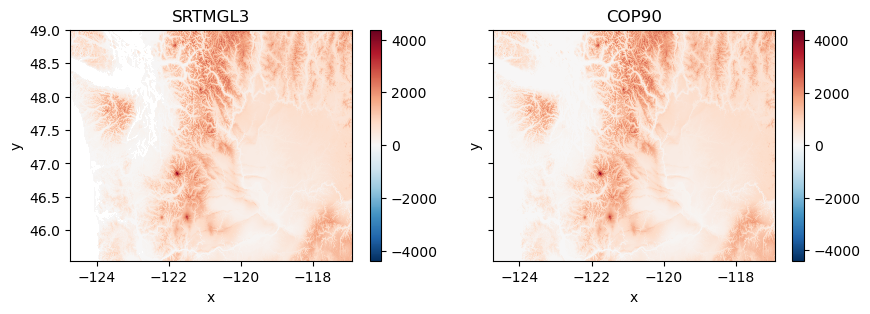

In [15]:
f, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))
srtm_wa_da.plot.imshow(ax=axs[0])
axs[0].set_title('SRTMGL3')
cop_wa_da.plot.imshow(ax=axs[1])
axs[1].set_title('COP90')

Xarray defaults to the RdBu colormap when there are negative values! Let's use a vmin and vmax to fix this.

Text(0.5, 1.0, 'COP90')

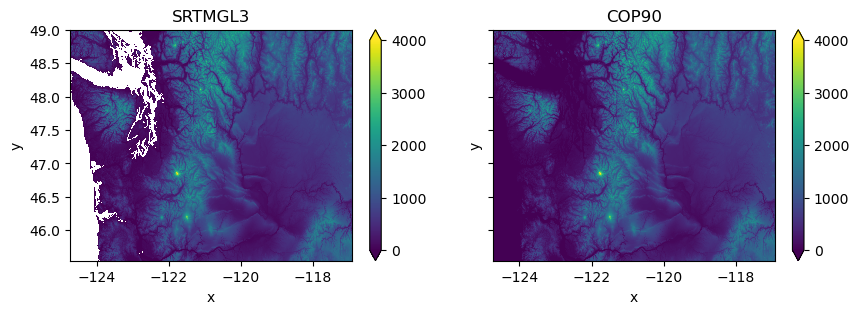

In [16]:
f, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))
srtm_wa_da.plot.imshow(ax=axs[0],vmin=0,vmax=4000)
axs[0].set_title('SRTMGL3')
cop_wa_da.plot.imshow(ax=axs[1],vmin=0,vmax=4000)
axs[1].set_title('COP90')

But the COP90 DEM is showing lots of 0 values around water...

### Set nodata value for Copernicus DEM to 0 
* Note: The Copernicus DEM creators filled water with values of 0.0 above the EGM2008 geoid (approximates mean sea level)
* We can set these to nodata to only consider land. This is a bit of a hack, and it is possible that there are real elevations at 0 m that will be masked here.  

In [17]:
print(f"nodata value for SRTMGL3: {srtm_wa_da.rio.nodata}")
print(f"nodata value for COP90: {cop_wa_da.rio.nodata}")

nodata value for SRTMGL3: nan
nodata value for COP90: None


In [18]:
cop_da = cop_wa_da.where(cop_wa_da != 0) # mask 0 values
cop_da = cop_da.rio.write_nodata(0) # update the attribute

In [19]:
print(f"nodata value for SRTMGL3: {srtm_wa_da.rio.nodata}")
print(f"nodata value for COP90: {cop_da.rio.nodata}")

nodata value for SRTMGL3: nan
nodata value for COP90: 0.0


Text(0.5, 1.0, 'COP90')

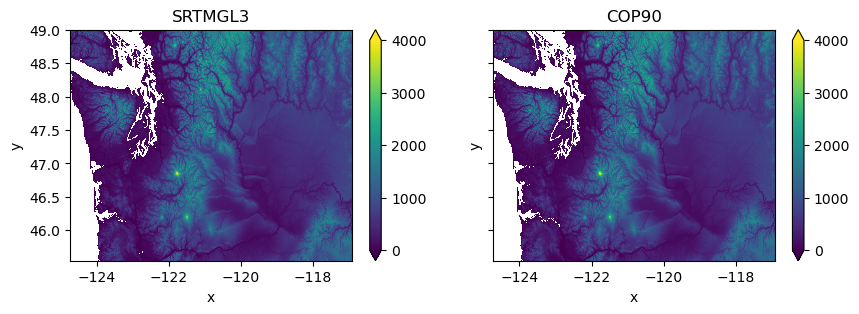

In [20]:
f, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))
srtm_wa_da.plot.imshow(ax=axs[0],vmin=0,vmax=4000)
axs[0].set_title('SRTMGL3')
cop_da.plot.imshow(ax=axs[1],vmin=0,vmax=4000)
axs[1].set_title('COP90')

## Raster reprojection
So easy to do in rioxarray!

#### Reproject the Copernicus DEM to UTM 10N
* The COP grids are distributed with crs of EPSG:4326
* Let's reproject to a more appropriate coordinate system for WA state
    * Use EPSG:32610

In [21]:
dst_crs = 'EPSG:32610'

In [22]:
cop_wa_utm_da = cop_wa_da.rio.reproject(dst_crs)
cop_wa_utm_da

<xarray.DataArray (y: 5851, x: 8877)> Size: 208MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 71kB 3.647e+05 3.648e+05 ... 9.748e+05 9.749e+05
  * y            (y) float64 47kB 5.446e+06 5.446e+06 ... 5.043e+06 5.043e+06
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

### Let's also try `gdalwarp` command-line utility
* A very simple, efficient way to accomplish this - let GDAL worry about all of the underlying math
* Review the documentation and options here: https://gdal.org/programs/gdalwarp.html
    * Resampling options: https://gdal.org/programs/gdalwarp.html#cmdoption-gdalwarp-r 
* Save the projected file as a GeoTiff on disk
    * Use `cubic` resampling algorithm
* Note the filesize using `ls -lh`

In [23]:
proj_fn = os.path.splitext(out_fn)[0]+'_utm_gdalwarp.tif'

In [24]:
%%time
if not os.path.exists(proj_fn):
    !gdalwarp -overwrite -r cubic -t_srs $dst_crs $out_fn $proj_fn

CPU times: user 25 µs, sys: 29 µs, total: 54 µs
Wall time: 48.2 µs


In [25]:
!ls -lh $proj_fn

-rw-rw-r-- 1 jovyan users 199M Feb 10 23:39 /home/jovyan/gda_demo_data/dem_data/WA_COP90_utm_gdalwarp.tif


In [26]:
!gdalinfo $proj_fn

Driver: GTiff/GeoTIFF
Files: /home/jovyan/gda_demo_data/dem_data/WA_COP90_utm_gdalwarp.tif
Size is 8877, 5851
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre

### A note about "creation options" when writing a new file to disk
* Review this great reference on GeoTiff file format: https://www.gdal.org/frmt_gtiff.html
    * See Creation Options section toward bottom of page: https://gdal.org/drivers/raster/gtiff.html#creation-options
* I almost always use `-co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER`
    * Uses lossless LZW compression (we explored in LS8 example comparing filesize on disk to your calculated array filesize)
    * Writes the tif image in "tiles" of 256x256 px instead of one large block - makes it much more efficient to read and extract a subwindow from the tif
    * If necessary, use the BIGTIFF format for files that are >4 GB

### Write out the same file, but this time use tiling and LZW compression
* Compare the new filesize on disk

In [27]:
proj_fn_lzw = os.path.splitext(out_fn)[0]+'_utm_gdalwarp_lzw.tif'

In [28]:
%%time
if not os.path.exists(proj_fn_lzw):
    !gdalwarp -r cubic -t_srs $dst_crs -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER $out_fn $proj_fn_lzw

CPU times: user 29 µs, sys: 33 µs, total: 62 µs
Wall time: 55.1 µs


In [29]:
!ls -lh $proj_fn_lzw

-rw-rw-r-- 1 jovyan users 177M Feb 10 23:41 /home/jovyan/gda_demo_data/dem_data/WA_COP90_utm_gdalwarp_lzw.tif


In [30]:
#Let's use the compressed file from here on out
#Should compare runtimes when using compressed vs. uncompressed
proj_fn = proj_fn_lzw

In [31]:
!gdalinfo $proj_fn

Driver: GTiff/GeoTIFF
Files: /home/jovyan/gda_demo_data/dem_data/WA_COP90_utm_gdalwarp_lzw.tif
Size is 8877, 5851
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["m

## Discussion Questions

* What is the original x and y pixel size and units?
  * Remember this is a 3-arcsecond grid
  * Info on an arcsecond: https://www.esri.com/news/arcuser/0400/wdside.html
* What is the projected x and y pixel size and units?
  * Is this consistent with your expectation for the 90-m Copernicus DEM or 3-arcsec SRTM data?
    * Hint: Think about the dimensions of a pixel in meters near the top and bottom of the unprojected raster. 
      * Roughly 45.5° and 49°
    * Then think back to Lab03 when we calculated length of a degree of longitude and a degree of latitude at different locations on the planet. 

In [32]:
print(f"the original x and y pixel size: {cop_wa_da.rio.resolution()}")
print(f"the reprojected x and y pixel size: {cop_wa_utm_da.rio.resolution()}")

the original x and y pixel size: (0.0008333333333333334, -0.0008333333333333334)
the reprojected x and y pixel size: (68.74846182011875, -68.74846182011875)


* Note that if the output resolution is unspecified, GDAL and rasterio will calcluate for you.
    * More info on the default "Suggested Warp Output" resolution: https://gdal.org/api/gdal_alg.html#_CPPv423GDALSuggestedWarpOutput12GDALDatasetH19GDALTransformerFuncPvPdPiPi
> ...resolution is computed with the intent that the length of the distance from the top left corner of the output imagery to the bottom right corner would represent the same number of pixels as in the source image. Note that if the image is somewhat rotated the diagonal taken isn’t of the whole output bounding rectangle, but instead of the locations where the top/left and bottom/right corners transform. The output pixel size is always square. This is intended to approximately preserve the resolution of the input data in the output file.
* But you can also specify this output resolution (`-tr` argument in `gdalwarp`), if, for example, you wanted to resample your output to 180 m resolution.

## Part 2: Create a shaded relief map (hillshade) from your projected DEM
* See background info on hillshades (and other DEM derivative products like slope and aspect) here: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm
* Can do this easily with `gdaldem` command line utility: https://gdal.org/programs/gdaldem.html
    * Try this and output to a new file
    * Note that if you were to run on a DEM with different horizontal and vertical units, (like say, degrees and meters), you will have scaling issues. There are ways around this, but always generate hillshade using a projected DEM.

In [33]:
hs_fn = os.path.splitext(proj_fn)[0]+'_hs.tif'

In [34]:
%%time
if not os.path.exists(hs_fn):
    !gdaldem hillshade $proj_fn $hs_fn

CPU times: user 19 µs, sys: 21 µs, total: 40 µs
Wall time: 47.9 µs


### Use rasterio to load your GDAL created hillshade 
* Note that the datatype is 8-bit (Byte), with values from 0-255 (it's a grayscale image, not elevation data)
* Make sure you mask nodata values

In [35]:
hs_wa_da = rxr.open_rasterio(hs_fn, masked=True).squeeze()
hs_wa_da

<xarray.DataArray (y: 5851, x: 8877)> Size: 208MB
[51939327 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 71kB 3.647e+05 3.648e+05 ... 9.748e+05 9.749e+05
  * y            (y) float64 47kB 5.446e+06 5.446e+06 ... 5.043e+06 5.043e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

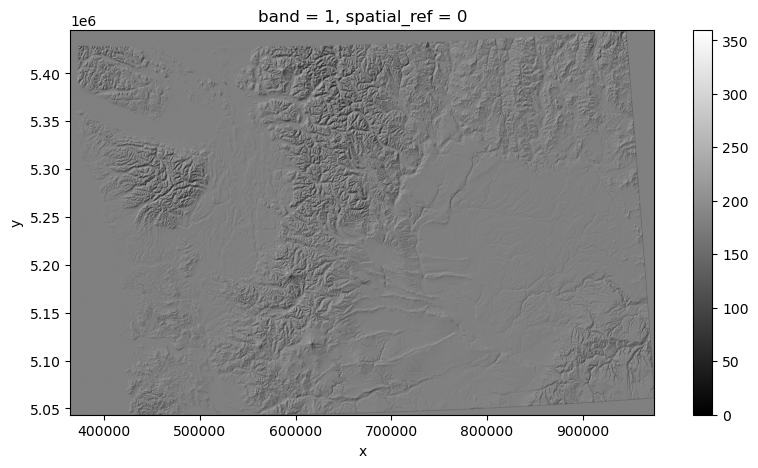

In [36]:
f,ax=plt.subplots(figsize=(10, 5))
hs_wa_da.plot.imshow(ax=ax,vmin=0,vmax=360,cmap='gray', interpolation='bilinear')
ax.set_aspect('equal')

## Part 3: Clipping Raster data

#### Load the states GeoDataFrame

In [37]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

GEO_ID STATE           NAME LSAD  CENSUSAREA  \
0  0400000US23    23          Maine        30842.923   
1  0400000US25    25  Massachusetts         7800.058   
2  0400000US26    26       Michigan        56538.901   
3  0400000US30    30        Montana       145545.801   
4  0400000US32    32         Nevada       109781.180   

                                            geometry  
0  MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ...  
1  MULTIPOLYGON (((-70.83204 41.6065, -70.82374 4...  
2  MULTIPOLYGON (((-88.68443 48.11578, -88.67563 ...  
3  POLYGON ((-104.0577 44.99743, -104.25014 44.99...  
4  POLYGON ((-114.0506 37.0004, -114.05 36.95777,...

#### Reproject the GeoDataFrame to match your DEM

In [38]:
states_gdf_proj = states_gdf.to_crs(dst_crs)

#### Isolate the WA state geometry object
* We want the geometry, not a GeoDataFrame or GeoSeries

In [39]:
wa_state = states_gdf_proj.loc[states_gdf_proj['NAME'] == 'Washington']
wa_geom = wa_state.iloc[0].geometry

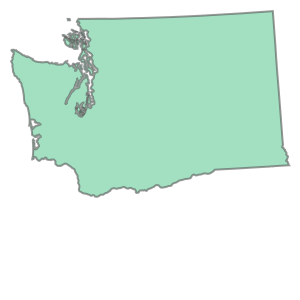

In [40]:
wa_geom

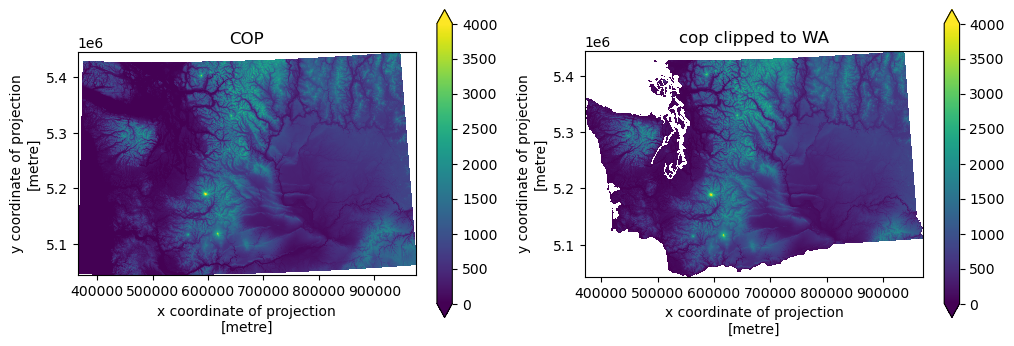

In [41]:
f,axs = plt.subplots(1,2, figsize=(12,4))
cop_wa_utm_da.plot.imshow(ax=axs[0],vmin=0,vmax=4000)
axs[0].set_title('COP')
axs[0].set_aspect('equal')
cop_wa_utm_da.rio.clip(wa_state.geometry).plot.imshow(ax=axs[1],vmin=0,vmax=4000)
axs[1].set_title('cop clipped to WA')
axs[1].set_aspect('equal')

## Part 4: Comparing and differencing rasters
* Often have two rasters with different resolution, extent, projection
* Want to combine, or use for some kind of raster math (e.g., subtract one from the other to compute difference)
* Relatively new package, `rioxarray` makes this very easy
    * https://corteva.github.io/rioxarray/stable/index.html
    * More on this in Week09 and Week10
    * Built for NetCDF model, but wraps rasterio for working with rasters
    * Lazy evaluation, doesn't read from disk util necessary
    * Built-in support for parallel operations using Dask

In [42]:
#Original SRTM DEM, still in EPSG:4326
print(f"Original SRTM DEM: {srtm_wa_da.rio.crs}")
print(f"Original SRTM dimensions: {srtm_wa_da.rio.shape}")
print(f"Reprojected COP DEM: {cop_wa_utm_da.rio.crs}")
print(f"Reprojected COP dimensions: {cop_wa_utm_da.rio.shape}")

Original SRTM DEM: EPSG:4326
Original SRTM dimensions: (4151, 9381)
Reprojected COP DEM: EPSG:32610
Reprojected COP dimensions: (5851, 8877)


In [43]:
#Projected COP DEM, reprojected in EPSG:32610
srtm_wa_utm_da = srtm_wa_da.rio.reproject_match(cop_wa_utm_da)

In [44]:
print(f"Reprojected SRTM DEM: {srtm_wa_utm_da.rio.crs}")
print(f"Reprojected SRTM dimensions: {srtm_wa_utm_da.rio.shape}")
print(f"Reprojected COP DEM: {cop_wa_utm_da.rio.crs}")
print(f"Reprojected COP dimensions: {cop_wa_utm_da.rio.shape}")

Reprojected SRTM DEM: EPSG:32610
Reprojected SRTM dimensions: (5851, 8877)
Reprojected COP DEM: EPSG:32610
Reprojected COP dimensions: (5851, 8877)


## Create a difference map
* Now that both rasters have identical projection, extent, and resolution, this is a simple subtraction

In [45]:
diff_da = cop_wa_utm_da - srtm_wa_utm_da

Text(0.5, 1.0, 'COP90 minus SRTMGL3')

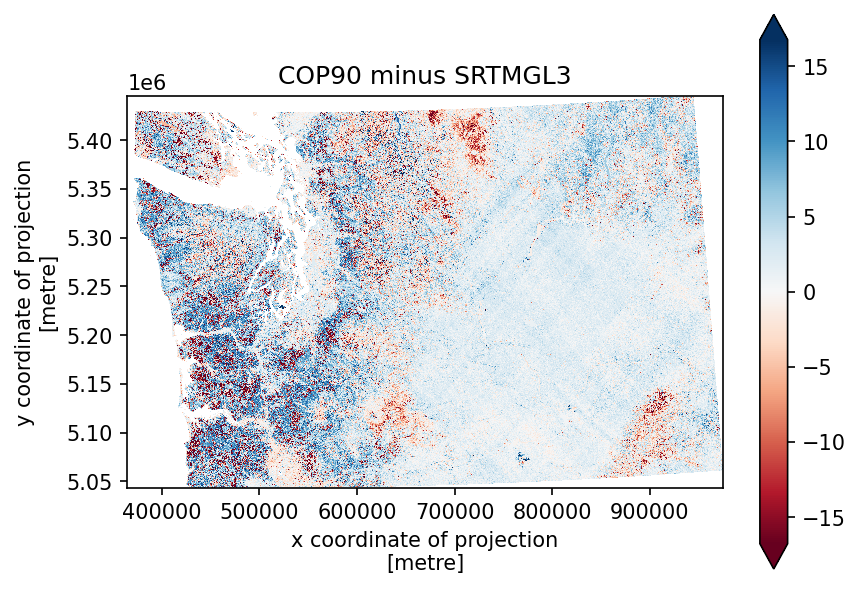

In [46]:
f, ax = plt.subplots(dpi=150)
diff_da.plot.imshow(cmap='RdBu', robust=True, ax=ax)
ax.set_aspect('equal')
ax.set_title('COP90 minus SRTMGL3')

Text(0.5, 1.0, 'COP90 minus SRTMGL3')

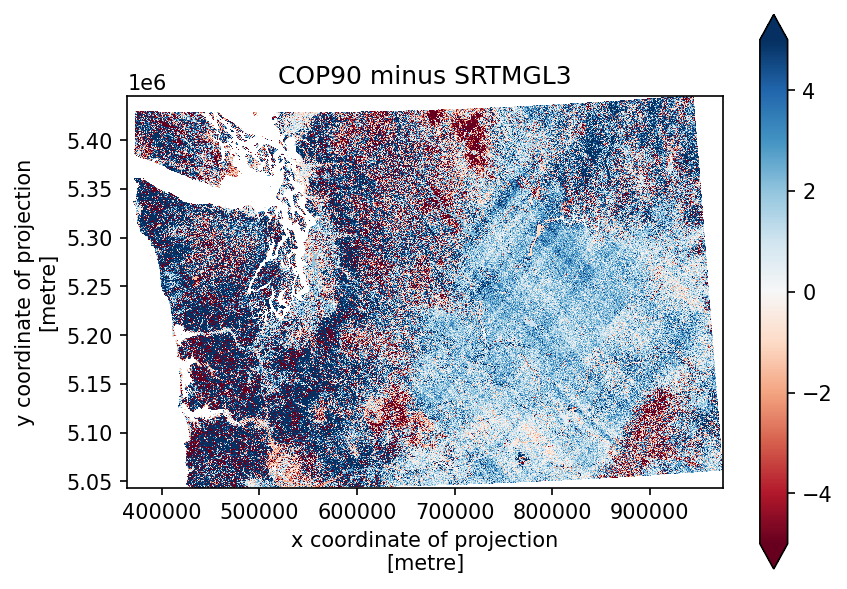

In [47]:
f, ax = plt.subplots(dpi=150)
diff_da.plot.imshow(cmap='RdBu', robust=True, vmin=-5, vmax=5, ax=ax)
ax.set_aspect('equal')
ax.set_title('COP90 minus SRTMGL3')

In [48]:
diff_da.median()

<xarray.DataArray ()> Size: 4B
array(1.5637817, dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [49]:
diff_da.mean()

<xarray.DataArray ()> Size: 4B
array(1.1240803, dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [50]:
diff_da.std()

<xarray.DataArray ()> Size: 4B
array(6.0349627, dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

## What about the vertical datum? 
* Remember that these DEMs contain elevation values that are relative to some reference surface, the vertical datum!
* The SRTM DEM uses the EGM96 geoid, while the Copernicus DEM uses the EGM2008 geoid. These are slightly different. https://en.wikipedia.org/wiki/Earth_Gravitational_Model
* So before we difference these DEMs, let's change the elevation values to be relative to the WGS84 ellipsoid. 
* We can use `gdalwarp` for this, but we need to download files that contain the offset between the geoid and the ellipsoid. https://proj.org/en/stable/usage/transformation.html 

In [51]:
# files containing vertical datum shifts
egm96 = '/home/jovyan/gda_demo_data/dem_data/egm96_15.gtx'
egm08 = '/home/jovyan/gda_demo_data/dem_data/egm08_25.gtx'

# download the files
if not os.path.exists(egm96):
    !wget -P $demdir https://download.osgeo.org/proj/vdatum/egm96_15/egm96_15.gtx
if not os.path.exists(egm08):
    !wget -P $demdir https://download.osgeo.org/proj/vdatum/egm08_25/egm08_25.gtx

In [52]:
# in files
cop90_wa_EGM08_fn = '/home/jovyan/gda_demo_data/dem_data/WA_COP90.tif'
srtm_wa_EGM96_fn = '/home/jovyan/gda_demo_data/dem_data/WA_SRTMGL3.tif'

# out files
cop90_wa_wgs84_ellipsoid_fn = '/home/jovyan/gda_demo_data/dem_data/WA_COP90_ellipsoid.tif'
srtm_wa_wgs84_ellipsoid_fn = '/home/jovyan/gda_demo_data/dem_data/WA_SRTMGL3_ellipsoid.tif'

In [53]:
# transform the vertical datum of our SRTM DEM
if not os.path.exists(srtm_wa_wgs84_ellipsoid_fn):
    !gdalwarp -s_srs "+proj=longlat +datum=WGS84 +no_defs +geoidgrids=/home/jovyan/gda_demo_data/dem_data/egm96_15.gtx" -t_srs "+proj=longlat +datum=WGS84 +no_def" $srtm_wa_EGM96_fn $srtm_wa_wgs84_ellipsoid_fn

In [54]:
# transform the vertical datum of our SRTM DEM
if not os.path.exists(cop90_wa_wgs84_ellipsoid_fn):
    !gdalwarp -s_srs "+proj=longlat +datum=WGS84 +no_defs +geoidgrids=/home/jovyan/gda_demo_data/dem_data/egm08_25.gtx" -t_srs "+proj=longlat +datum=WGS84 +no_def" $cop90_wa_EGM08_fn $cop90_wa_wgs84_ellipsoid_fn

In [55]:
# read DEMs back in
srtm_wa_da = rxr.open_rasterio(srtm_wa_wgs84_ellipsoid_fn, masked=True).squeeze()
cop_wa_da = rxr.open_rasterio(cop90_wa_wgs84_ellipsoid_fn, masked=True).squeeze()

In [56]:
srtm_wa_utm_da = srtm_wa_da.rio.reproject(dst_crs)

In [57]:
cop_wa_utm_da = cop_wa_da.rio.reproject_match(srtm_wa_utm_da)

In [58]:
diff_da = cop_wa_utm_da - srtm_wa_utm_da

Text(0.5, 1.0, 'COP90 minus SRTMGL3')

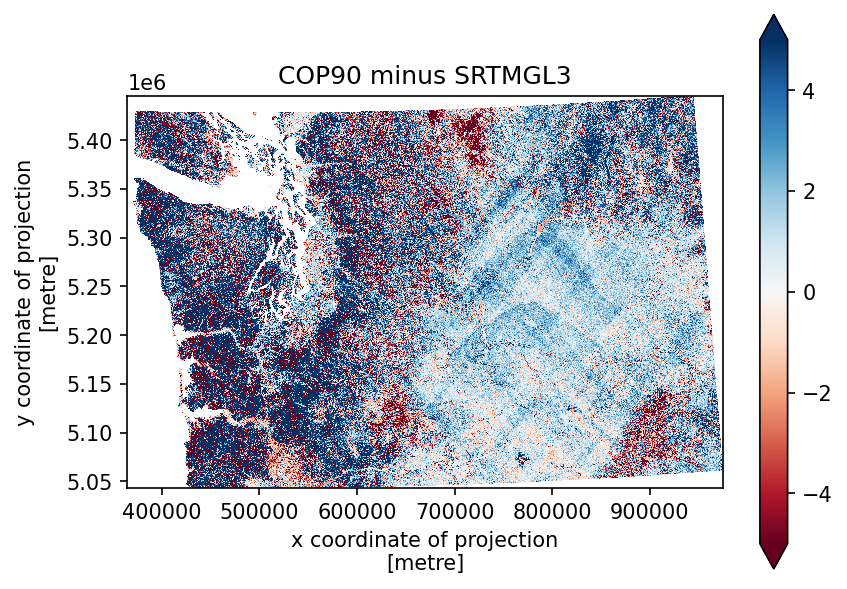

In [59]:
f, ax = plt.subplots(dpi=150)
diff_da.plot.imshow(cmap='RdBu', robust=True, vmin=-5, vmax=5, ax=ax)
ax.set_aspect('equal')
ax.set_title('COP90 minus SRTMGL3')

In [60]:
diff_da.median()

<xarray.DataArray ()> Size: 4B
array(1.2817993, dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [61]:
diff_da.mean()

<xarray.DataArray ()> Size: 4B
array(1.0107714, dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [62]:
diff_da.std()

<xarray.DataArray ()> Size: 4B
array(6.018347, dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

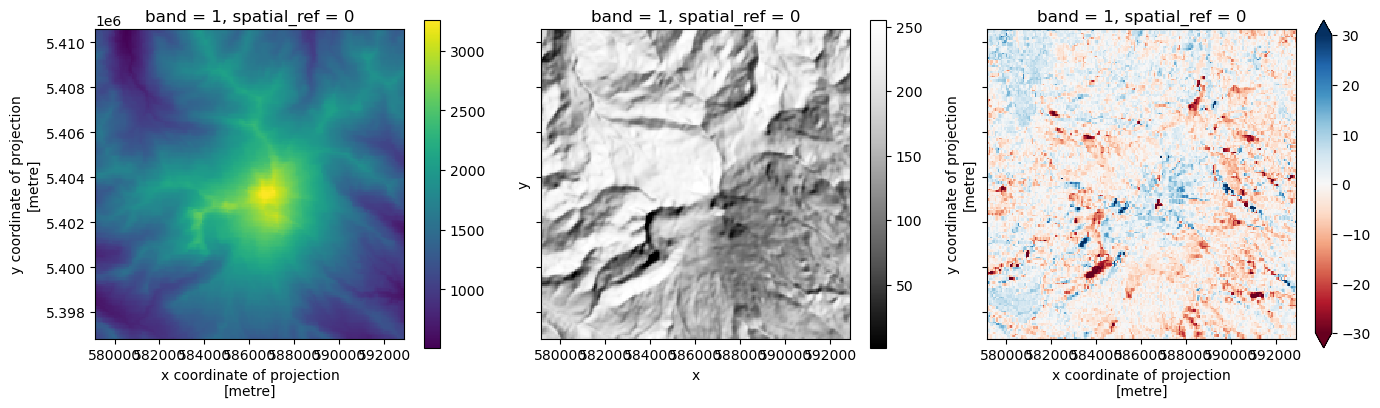

In [63]:
# plot change at Mt. Baker
f, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
cop_wa_utm_da.isel(x=slice(3120, 3320), y=slice(510, 710)).plot(ax=ax[0])
hs_wa_da.isel(x=slice(3120, 3320), y=slice(510, 710)).plot(ax=ax[1], cmap='Grays_r')
diff_da.isel(x=slice(3120, 3320), y=slice(510, 710)).plot(ax=ax[2], vmin=-30, vmax=30, cmap='RdBu')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
plt.tight_layout()

### Save output raster to disk

In [64]:
diff_fn = 'WA_COP90_SRTMGL3_diff.tif'

In [65]:
diff_da.rio.to_raster(diff_fn)

In [66]:
!gdalinfo $diff_fn

Driver: GTiff/GeoTIFF
Files: WA_COP90_SRTMGL3_diff.tif
Size is 8877, 5851
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],


## Profile plot

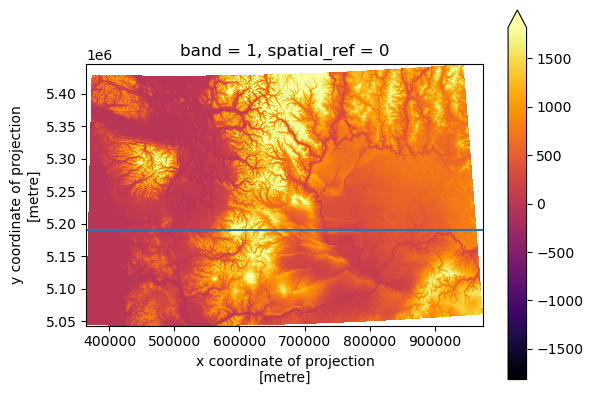

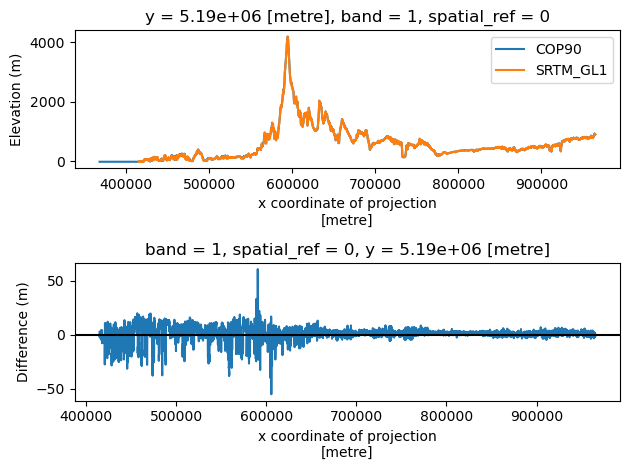

In [67]:
#y=5300000
y=5190000
f, ax = plt.subplots()
cop_wa_utm_da.plot.imshow(cmap='inferno', robust=True, ax=ax)
ax.set_aspect('equal')
ax.axhline(y)

f, axs = plt.subplots(2, 1)
cop_wa_utm_da.sel(y=y, method='nearest').plot(ax=axs[0], label='COP90')
srtm_wa_utm_da.sel(y=y, method='nearest').plot(ax=axs[0], label='SRTM_GL1')
axs[0].legend()
axs[0].set_ylabel('Elevation (m)')
diff_da.sel(y=y, method='nearest').plot(ax=axs[1])
axs[1].axhline(0, color='k')
axs[1].set_ylabel('Difference (m)')
plt.tight_layout()

## Some other newer packages worth exploring

### Work in Progress: xarray-spatial
* Newer project implementing many raster/DEM analysis functions in Python with Dask/CUDA support
* Uses xarray data model (more complicated than rasterio dataset model)
* https://xarray-spatial.org/
* Surface functions: https://github.com/makepath/xarray-spatial#surface
    * Hillshade: https://xarray-spatial.org/reference/_autosummary/xrspatial.hillshade.hillshade.html#xrspatial.hillshade.hillshade

In [68]:
#import xrspatial

In [69]:
#Run the hillshade operation
#hs = xrspatial.hillshade(cop_xds, azimuth=315, angle_altitude=45)
#Note: there are some coordinate scaling and nodata issues here
#hs.plot.imshow(cmap='gray');

## xdem
* https://xdem.readthedocs.io/en/latest/quick_start.html